# Preprocessing and Importing of SARIG Datasets

In [266]:
import os
import json
import numpy as np
import pandas as pd
from osgeo import gdal
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from raster2xyz.raster2xyz import Raster2xyz

## Display the TIFF input dataset

In [280]:
def convert_TIFF_RGB(tiff_path):
    '''
    Converts an input TIFF file into a numpy array
    Takes approx 20sec to execute 
    '''
    # Load TIFF file
    ds = gdal.Open(tiff_path, gdal.GA_ReadOnly) 

    # Extract Raster Bands
    numBands = ds.RasterCount;
    rasterBands = []
    for i in range(1,numBands):
        rasterBands.append(ds.GetRasterBand(i).ReadAsArray())
    ds = None
    
    # Flatten bands into a single array
    return np.dstack(tuple(rasterBands))

def display_TIFF(tiff_path, title=None, rot90=False):
    '''
    Displays a TIFF file.
    Takes approx 1:10min to execute 
    @param bool rot90: Rotate the image 90 deg
    '''
    # Load TIFF
    nArray = convert_TIFF_RGB(tiff_path)
    if True: nArray = np.rot90(nArray)

    plt.figure(figsize=(10, 14))
    plt.imshow(nArray)
    if (title!=None): plt.title(title)

    # Setup the colorbar
    normalize = mcolors.Normalize(vmin=nArray.min(), vmax=nArray.max())
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cm.jet)
    scalarmappaple.set_array(nArray)
    plt.colorbar(scalarmappaple)

    # Show the figure
    plt.show()

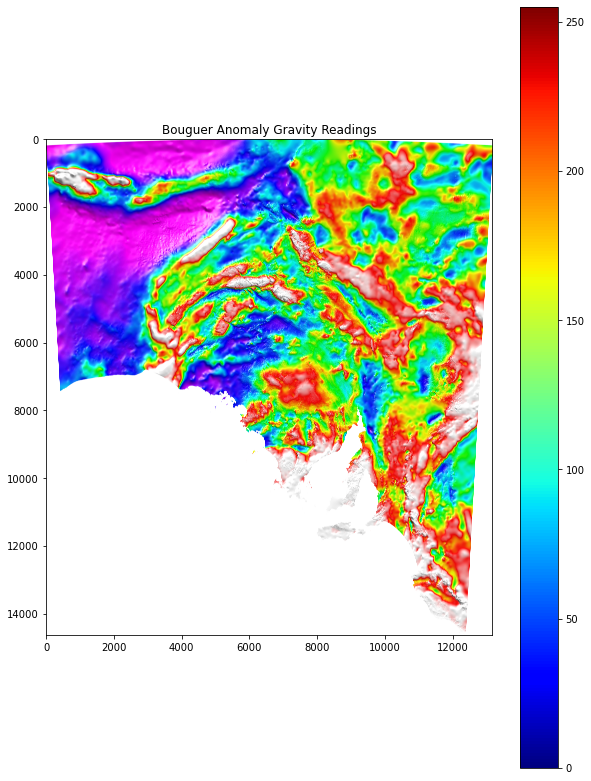

In [281]:
tiff_path = "c:\\Users\\marcr\\OneDrive - UNSW\\Uni\\MMAN4020\\repo\\data\\SA_GRAV_TIF\\sa_grav_onshore.tif"
display_TIFF(tiff_path, title="Bouguer Anomaly Gravity Readings", rot90=True)

## Convert TIFF dataset to CSV dataframe

In [269]:
def save_XYZ(tiff_path, xyz_path):
    ''' 
    Load a TIFF and save it as a .XYZ file
    Takes approx 15min to execute 
    @param string tiff_path: Input TIFF path
    @param string xyz_output_path: Output XYZ path
    '''
    ds = gdal.Open(tiff_path)
    gdal.Translate(xyz_path, ds)

def save_CSV(tiff_path, csv_path):
    ''' 
    Loads TIFF file and saves it as a csv file.
    Creates an XYZ array of only 1 bandwidth
    Takes approx 15min to execute 
    @param string tiff_path: Input TIFF path
    @param string csv_output_path: Output CSV path
    '''
    rtxyz = Raster2xyz()
    rtxyz.translate(tiff_path, csv_path)

def load_CSV(csv_path):
    ''' 
    Loads CSV file and outputs pandas dataframe
    Takes 3sec to execute
    '''
    if not os.path.isfile(csv_path): print("Invalid Path")
    else: return pd.read_csv(csv_path)
    
def load_GeoJSON(json_path):
    ''' 
    Loads GeoJSON or TopoJSON
    '''
    if not os.path.isfile(json_path): print("Invalid Path")
    else: 
        f = open(json_path,)
        return json.load(f)
    

In [3]:
save_CSV(tiff_path, 'sa_grav.csv')

[2021-10-13 02:09:19 - INFO] - Getting geotransform and data...
[2021-10-13 02:09:27 - INFO] - Getting XYZ data...
[2021-10-13 02:09:49 - INFO] - Getting geotransformed coordinates...
[2021-10-13 02:12:54 - INFO] - Building XYZ data...


In [270]:
df = load_CSV('sa_grav_onshore.csv')

## Calculate Global Coordinates (Longitude, Latitude) of Data-Entries

In [272]:
def get_globalCoords(df, boundingCoords, scale=1):
    '''
    Adds global coordinates to a pandas dataframe given the images
    bounding coordinates.\n
    Takes 40sec to execute if scale = 1, otherwise 4sec if scale = 10
    @param pandas-dataframe df: .XYZ Dataframe of a GeoTIFF
    @param tuple boundingCoords: Bounding Longitude & Latitude of the survey 
    area. (Nth Lat, Sth Lat, Est Long, Wst Long)
    @param int scale: Scales the dataframe down by this degree. (i.e. if scale
    equals 10 then every 10th row is kept so each box is 10km^2 in size)
    '''
    
    # Scale down dataframe
    df = df.iloc[::scale].reset_index()
    ### TO DO ###
    # Instead of extracting every 10th row, average out the every 10rows and combine them.
    # This would be more accurate

    # Each pixel represents a cell of land of either 100m^2, 200m^2, 400m^2 or 800m^2
    cell_dimensions = (df['x'][1]-df['x'][0])

    # Calculate the location position of each value in the dataframe
    # Calculate each values pixel position in the TIFF image
    init_x, init_y = df['x'][0], df['y'][0]
    df['x'] = df['x'].sub(init_x).div(cell_dimensions).astype(int)
    df['y'] = df['y'].sub(init_y).div(-1*cell_dimensions).astype(int)

    # Global coordinates of the surveyed area obtained from datasheet
    g_NTH, g_STH, g_EST, g_WST = boundingCoords

    # Calculate longitude and latitude of each point
    rastor_width, rastor_height = df['x'].iloc[-1], df['y'].iloc[-1]
    width_inc = (g_WST - g_EST) / rastor_width
    height_inc = (g_STH - g_NTH) / rastor_height

    df['x'] = df['x'].mul(width_inc).add(g_EST)
    df['y'] = df['y'].mul(height_inc).add(g_NTH)
    df['z'] = df['z'].div(255).astype(float)

    df["Coordinate"] = list(zip(df['x'], df['y']))
    df['top_right'] =  list(zip(df['x'].add(width_inc), df['y']))
    df['bot_right']  =  list(zip(df['x'].add(width_inc), df['y'].add(height_inc)))
    df['bot_left'] = list(zip(df['x'], df['y'].add(height_inc)))
    df['BoxPoints'] = list(zip(df["Coordinate"], df['top_right'], df['bot_right'], df["bot_left"], df["Coordinate"]))

    df = df.rename(columns={'z':'Weight'})
    df = df[['Weight','Coordinate','BoxPoints']]

    return df

In [273]:
df = load_CSV('sa_grav_onshore.csv')
boundingCoords = (-24.8220, -40.1350,  126.7810, 142.2730)
global_df = get_globalCoords(df, boundingCoords, scale=10)
global_df

,Weight,Coordinate,BoxPoints
0,1.0,"(126.781, -24.822)","((126.781, -24.822), (126.87546341463415, -24...."
1,1.0,"(126.87546341463415, -24.822)","((126.87546341463415, -24.822), (126.969926829..."
2,1.0,"(126.9699268292683, -24.822)","((126.9699268292683, -24.822), (127.0643902439..."
3,1.0,"(127.06439024390245, -24.822)","((127.06439024390245, -24.822), (127.158853658..."
4,1.0,"(127.15885365853659, -24.822)","((127.15885365853659, -24.822), (127.253317073..."
...,...,...,...
327584,1.0,"(141.8951463414634, -40.135)","((141.8951463414634, -40.135), (141.9896097560..."
327585,1.0,"(141.98960975609756, -40.135)","((141.98960975609756, -40.135), (142.084073170..."
327586,1.0,"(142.0840731707317, -40.135)","((142.0840731707317, -40.135), (142.1785365853..."
327587,1.0,"(142.17853658536586, -40.135)","((142.17853658536586, -40.135), (142.273, -40...."


## Display Data: Create geoJSON and Polygons

In [274]:
import folium
import geopandas 
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

def create_geoJSON(polygons_pts, outputJSON=None):
    ''' 
    Create geoJSON file from the polygons points
    '''
    feature_list = []
    for pts in polygons_pts:
        polygon = Polygon([pts])
        feature = Feature(geometry=polygon, properties={"Weight": 200}, id=1)
        feature_list.append(feature)
    geoJSON = FeatureCollection(feature_list)
    # topoJSON = tp.Topology(geoJSON, prequantize=False).to_json()
    topoJSON = geoJSON
    if outputJSON != None:
        with open(outputJSON, 'w+') as f:
            json.dump(topoJSON, f)
    return topoJSON

def merge_polygons(polygons_pts, ratio=0.01):
    ''' 
    Merges adjacent polygons
    @param list polygons_pts: List of polygon
    coordinates
    @param int ratio: Ratio to simplify 
    the overal polygons shape
    @return shapely.geometry.multipolygon.MultiPolygon
    '''
    multi_polygon = []
    for pts in polygons_pts:
        polygon = Polygon(pts)
        multi_polygon.append(polygon)
    shapefile = cascaded_union(multi_polygon).simplify(ratio)
    return shapefile

def display_shapely(shapely1, shapely2):
    ''' 
    Given 2 multi-polygon shapely objects plot both of them
    '''
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    st = fig.suptitle("Areas with High Gravitational Readings", fontsize="x-large")
    axes[0].set_aspect('equal', 'datalim')
    axes[1].set_aspect('equal', 'datalim')
    
    # Calculate number of points in both shapely polygons
    shapely1_num_pts = len([point for polygon in shapely1 for point in polygon.exterior.coords[:-1]])
    shapely2_num_pts = len([point for polygon in shapely2 for point in polygon.exterior.coords[:-1]])
    axes[0].set_title(f"Original Polygons: {shapely1_num_pts} pts")
    axes[1].set_title(f"Simplified Polygons: {shapely2_num_pts} pts")

    for geom in shapely1.geoms:    
        xs, ys = geom.exterior.xy    
        axes[0].fill(xs, ys, alpha=0.5, fc='r', ec='none')
    for geom in shapely2.geoms:    
        xs, ys = geom.exterior.xy    
        axes[1].fill(xs, ys, alpha=0.5, fc='r', ec='none')

    plt.show()
    


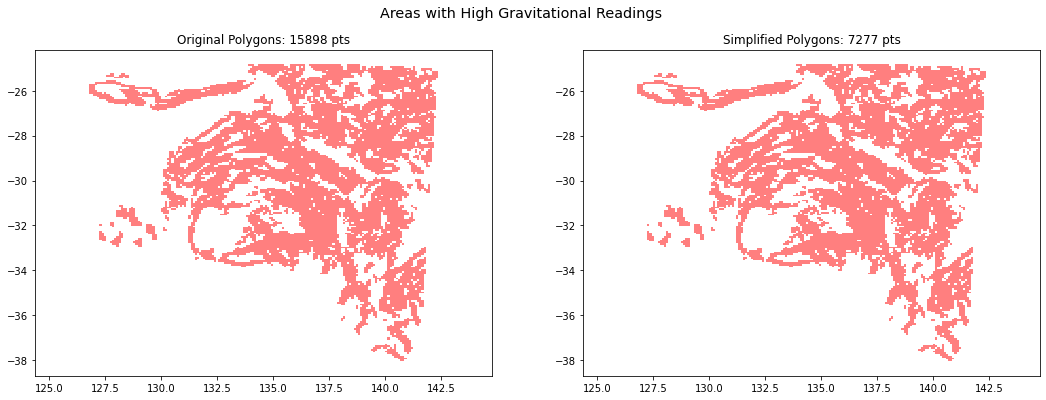

In [275]:
# Isolate areas that have high readings
high_df = global_df.loc[global_df['Weight'] < 0.01].reset_index()

# Simplify the polygon
polygon_pts = high_df['BoxPoints'].tolist()[:]
shapely_polygons = merge_polygons(polygon_pts)

# Convert list of pts to shapely Polygon() and display both 
init_polygon = cascaded_union([Polygon(x) for x in polygon_pts])
display_shapely(init_polygon, shapely_polygons)

## Create ShapeFile and Display Data on Map

In [276]:
def create_shapefile(shapely_polygons, output_path):
    ''' 
    Create shapefile from shapely.geometry 
    @param shapely_polygons: shapely.geometry
    @param string output_path: Path string
    '''
    # Define a polygon feature geometry with one attribute
    schema = {
        'geometry': 'Polygon',
        'properties': {'id': 'int'},
    }

    # Write a new Shapefile
    with fiona.open(output_path, 'w', 'ESRI Shapefile', schema) as c:
        ## If there are multiple geometries, put the "for" loop here
        c.write({
            'geometry': mapping(shapely_polygons),
            'properties': {'id': 123},
        })
        pass
    
def display_shapefile_interactive(filename): 
    ''' 
    Return folium map object
    '''
    grav_gdf = geopandas.read_file(filename)
    grav_gdf.crs = "EPSG:4326"

    map = folium.Map(location=[-32, 135],tiles="cartodb positron", zoom_start=6)
    # folium.GeoJson(data=grav_gdf["geometry"]).add_to(map)

    folium.GeoJson(
        data=grav_gdf["geometry"],
        style_function= lambda x :{
            'fillColor':'rgb(255,150,50, 1)', 
            'fillOpacity': 0.5,
            "stroke" : False,
            },
        highlight_function=lambda feature: {
            'fillColor':'green', 
            'fillOpacity': 0.5,
            "stroke" : False,
            },
        name="Footprint",
        ).add_to(map)
    return map

In [278]:
create_shapefile(shapely_polygons, 'grav.shp')

In [279]:
display_shapefile_interactive('grav.shp')

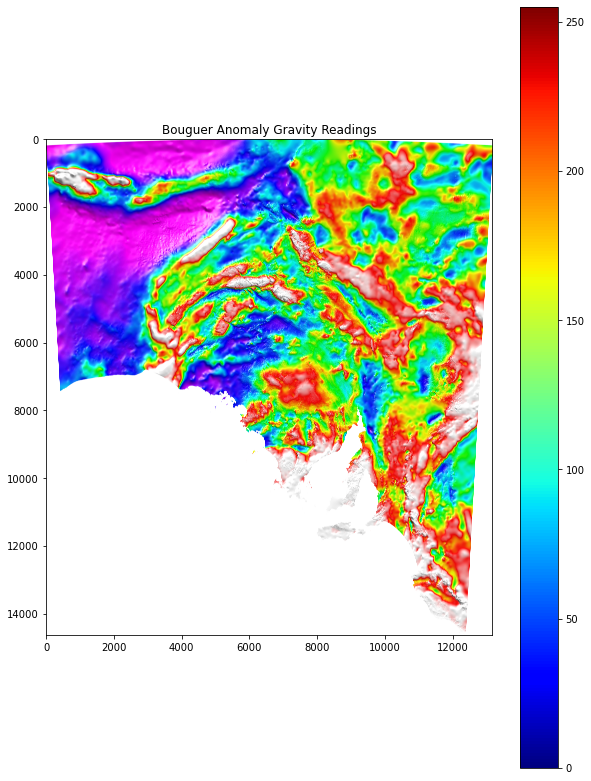

In [282]:
display_TIFF(tiff_path, title="Bouguer Anomaly Gravity Readings", rot90=True)